In [1]:
#mounting the data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Importing the required Libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
#Using the GPU
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
train_dir = '/content/drive/MyDrive/Animal_Stratified/train'
val_dir = '/content/drive/MyDrive/Animal_Stratified/val'
test_dir = "/content/drive/MyDrive/Animal_Stratified/test"

In [5]:
#Data Augumentation
# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]

    # Data augmentation parameters
    rotation_range=20,  # Random rotation between -20 and +20 degrees
    width_shift_range=0.2,  # Random horizontal shift by ±20% of width
    height_shift_range=0.2,  # Random vertical shift by ±20% of height
    zoom_range=0.2,  # Random zoom between 80% and 120%
    horizontal_flip=True,  # Random horizontal flipping
    vertical_flip=False,  # No vertical flipping (can enable if appropriate)
    fill_mode='nearest'  # Strategy for filling in newly created pixels
)

# Validation and test generators (only rescaling, no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
# Set image size and batch size
img_width, img_height = 224, 224  # Adjust as needed
batch_size = 32  # Adjust as needed

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'  # or 'binary' if you have two classes
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important for evaluating the test set
)

Found 3000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


In [7]:
#Get the classnames and number of classes
test_generator.class_indices

{'Canadagoose': 0,
 'RainbowLorikeets': 1,
 'blackswan': 2,
 'crane': 3,
 'echidnas': 4,
 'hummingbird': 5,
 'jacamar': 6,
 'koala': 7,
 'merganser': 8,
 'toucan': 9}

In [8]:
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)
print(f"Class names: {class_names}")
print(f"Number of classes: {num_classes}")

Class names: ['Canadagoose', 'RainbowLorikeets', 'blackswan', 'crane', 'echidnas', 'hummingbird', 'jacamar', 'koala', 'merganser', 'toucan']
Number of classes: 10


In [9]:
#Building a custom model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,250 (42.61 MB)

 Trainable params: 11,170,250 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
epochs = 10
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 1392s 15s/step - accuracy: 0.1543 - loss: 2.9071 - precision: 0.2321 - recall: 0.0218 - val_accuracy: 0.3175 - val_loss: 1.9996 - val_precision: 0.5538 - val_recall: 0.1401
Epoch 2/10
 1/93 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.4062 - loss: 1.8370 - precision: 0.8000 - recall: 0.1250

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.4062 - loss: 1.8370 - precision: 0.8000 - recall: 0.1250 - val_accuracy: 0.2893 - val_loss: 2.1477 - val_precision: 0.4569 - val_recall: 0.1603
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 61s 656ms/step - accuracy: 0.3632 - loss: 1.8584 - precision: 0.5764 - recall: 0.0808 - val_accuracy: 0.3569 - val_loss: 1.9765 - val_precision: 0.4506 - val_recall: 0.2208
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.2500 - loss: 2.0484 - precision: 0.4444 - recall: 0.1250 - val_accuracy: 0.3972 - val_loss: 1.8036 - val_precision: 0.5264 - val_recall: 0.2510
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 81s 878ms/step - accuracy: 0.4148 - loss: 1.6784 - precision: 0.5803 - recall: 0.1426 - val_accuracy: 0.4143 - val_loss: 1.6949 - val_precision: 0.6062 - val_recall: 0.2157
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.5312 - loss: 1.4080 - precision: 0.6667 - recall: 0.2500 - val_accuracy: 0.4113 - val_loss: 1.6760 - val_p

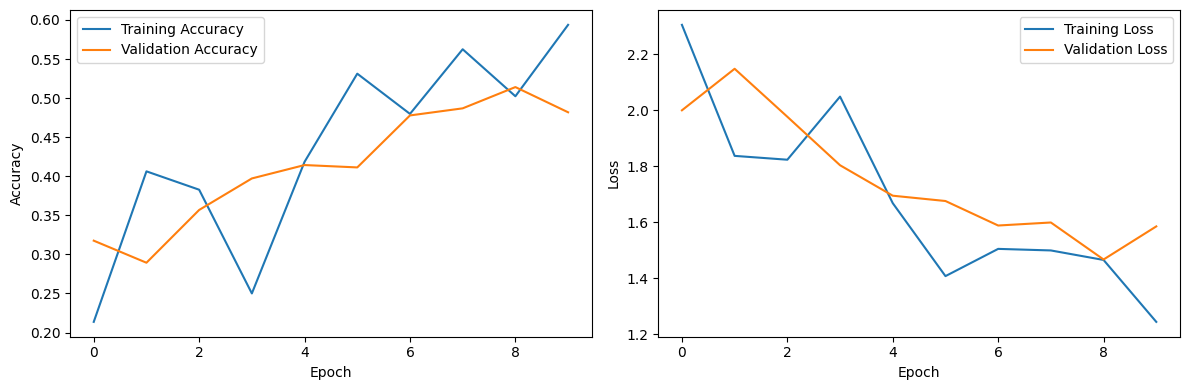

In [12]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

In [13]:
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_generator)
print(f'\nTest accuracy: {test_acc:.4f}')
print(f'Test precision: {test_precision:.4f}')
print(f'Test recall: {test_recall:.4f}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 166s 11s/step - accuracy: 0.4130 - loss: 1.7889 - precision: 0.5879 - recall: 0.2730

Test accuracy: 0.5100
Test precision: 0.7137
Test recall: 0.3240


In [14]:
test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.samples // batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step


In [15]:
true_classes = test_generator.classes

In [16]:
print('\nClassification Report:')
print(classification_report(true_classes, predicted_classes, target_names=class_names))

# Confusion matrix
conf_mat = confusion_matrix(true_classes, predicted_classes)
print('\nConfusion Matrix:')
print(conf_mat)


Classification Report:
                  precision    recall  f1-score   support

     Canadagoose       0.25      0.04      0.07        50
RainbowLorikeets       0.81      0.52      0.63        50
       blackswan       0.35      0.66      0.46        50
           crane       0.36      0.42      0.39        50
        echidnas       0.48      0.98      0.64        50
     hummingbird       0.80      0.24      0.37        50
         jacamar       0.74      0.28      0.41        50
           koala       0.55      0.68      0.61        50
       merganser       0.60      0.68      0.64        50
          toucan       0.59      0.60      0.59        50

        accuracy                           0.51       500
       macro avg       0.55      0.51      0.48       500
    weighted avg       0.55      0.51      0.48       500


Confusion Matrix:
[[ 2  0  5 15 13  0  0  4 10  1]
 [ 0 26  7  3  1  1  1  3  0  8]
 [ 0  0 33  3  8  1  0  2  3  0]
 [ 0  1  8 21  9  0  0  4  3  4]
 [ 0  0  1

In [17]:
#Using Transfer Learning models
from tensorflow.keras.applications import (VGG16, ResNet50, MobileNet,
                                          InceptionV3, EfficientNetB0)
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

model_comparison = []

In [18]:
#1. VGG16
def evaluate_vgg16():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy',
                         tf.keras.metrics.Precision(name='precision'),
                         tf.keras.metrics.Recall(name='recall')])

    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=10,
        callbacks=[EarlyStopping(patience=3)]
    )

    return model, history

vgg_model, vgg_history = evaluate_vgg16()
model_comparison.append({
    'Model': 'VGG16',
    'Val Accuracy': max(vgg_history.history['val_accuracy']),
    'Val Precision': max(vgg_history.history['val_precision']),
    'Val Recall': max(vgg_history.history['val_recall']),
    'Parameters': f"{vgg_model.count_params():,}",
    'Inference Time': 'Medium',
    'Best For': 'Medium-sized datasets'
})

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 94s 863ms/step - accuracy: 0.1481 - loss: 2.3315 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4780 - val_loss: 1.9422 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 68s 727ms/step - accuracy: 0.3924 - loss: 1.9265 - precision: 0.3684 - recall: 6.0878e-04 - val_accuracy: 0.5560 - val_loss: 1.6839 - val_precision: 1.0000 - val_recall: 0.0010
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 66s 704ms/step - accuracy: 0.5095 - loss: 1.6900 - precision: 0.9199 - recall: 0.0117 - val_accuracy: 0.6180 - val_loss: 1.5050 - val_precision: 0.9667 - val_recall: 0.0290
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 65s 694ms/step - accuracy: 0.5633 - loss: 1.5375 - precision: 0.8740 - recall: 0.0453 - val_accuracy: 0.6100 - val_loss: 1.3909 - val_precision: 0.8923 - val_recall: 0.1160
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 67s 718ms/step - accuracy: 0.5829 - loss: 1.429

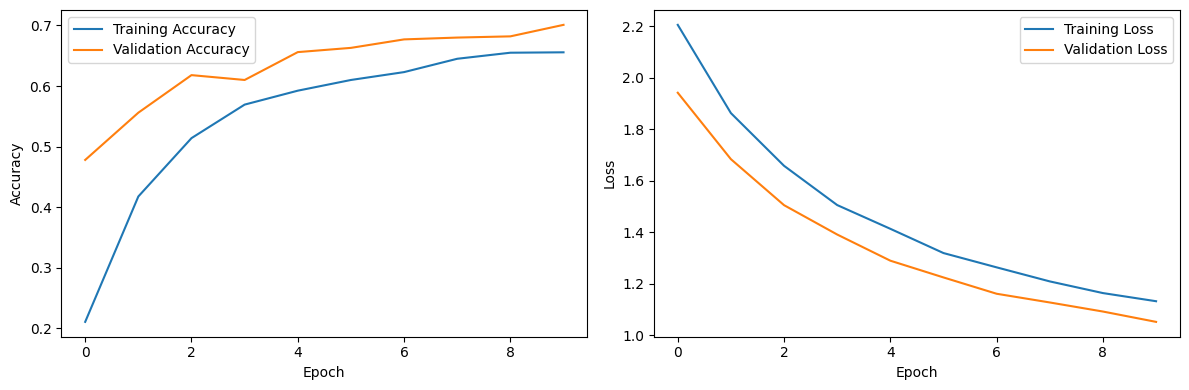

16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 815ms/step - accuracy: 0.6309 - loss: 1.1689 - precision: 0.7962 - recall: 0.2743

Test accuracy: 0.7100
Test precision: 0.9108
Test recall: 0.3880
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 310ms/step


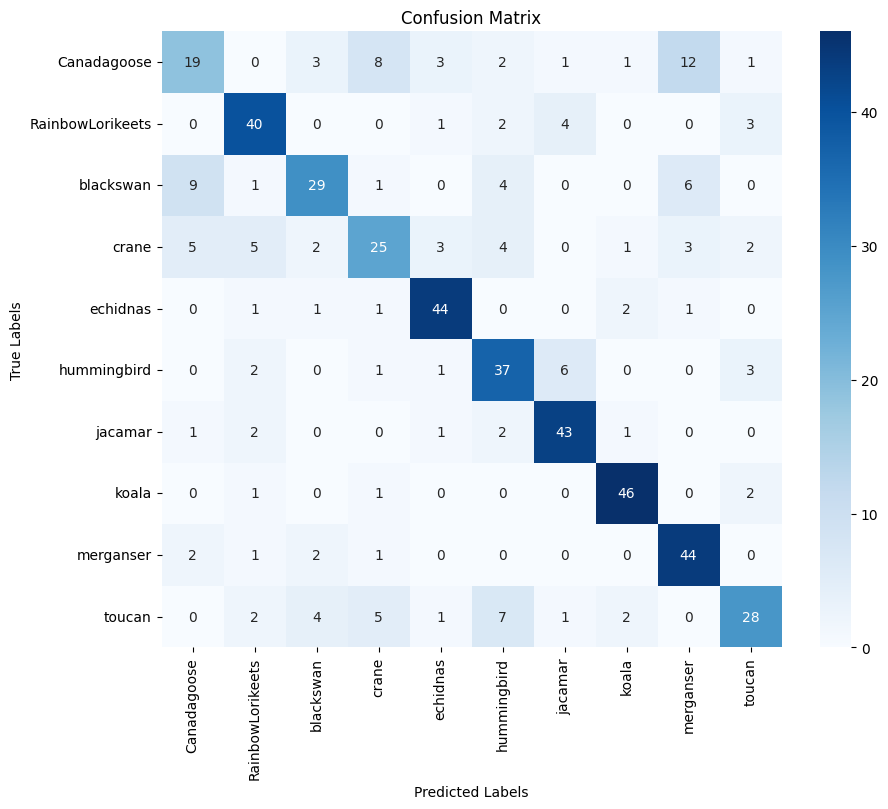

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(vgg_history)


# Evaluate on test set (assuming you have a test_generator)
test_generator.reset() # Reset the generator before evaluating
test_loss, test_acc, test_precision, test_recall = vgg_model.evaluate(test_generator)
print(f'\nTest accuracy: {test_acc:.4f}')
print(f'Test precision: {test_precision:.4f}')
print(f'Test recall: {test_recall:.4f}')


# Generate predictions
predictions = vgg_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes
true_classes = test_generator.classes

# Confusion Matrix
conf_mat = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [20]:
#2. RESNET50
def evaluate_resnet50():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = tf.keras.applications.resnet50.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy', 'precision', 'recall'])

    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=10,
        callbacks=[EarlyStopping(patience=3)]
    )

    return model, history

resnet_model, resnet_history = evaluate_resnet50()
model_comparison.append({
    'Model': 'ResNet50',
    'Val Accuracy': max(resnet_history.history['val_accuracy']),
    'Val Precision': max(resnet_history.history['val_precision']),
    'Val Recall': max(resnet_history.history['val_recall']),
    'Parameters': f"{resnet_model.count_params():,}",
    'Inference Time': 'Medium',
    'Best For': 'General purpose'
})

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 91s 820ms/step - accuracy: 0.0921 - loss: 2.4598 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.1910 - val_loss: 2.2525 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 64s 677ms/step - accuracy: 0.1276 - loss: 2.2997 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2360 - val_loss: 2.2199 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 62s 664ms/step - accuracy: 0.1684 - loss: 2.2502 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.1870 - val_loss: 2.2008 - val_precision: 1.0000 - val_recall: 0.0020
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 63s 670ms/step - accuracy: 0.1645 - loss: 2.2360 - precision: 0.1149 - recall: 1.3995e-04 - val_accuracy: 0.1810 - val_loss: 2.1741 - val_precision: 0.5556 - val_recall: 0.0050
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 63s 670ms/step - accura

In [21]:
#3. MobileNet
def evaluate_mobilenet():
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy', 'precision', 'recall'])

    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=10,
        callbacks=[EarlyStopping(patience=3)]
    )

    return model, history

mobilenet_model, mobilenet_history = evaluate_mobilenet()
model_comparison.append({
    'Model': 'MobileNet',
    'Val Accuracy': max(mobilenet_history.history['val_accuracy']),
    'Val Precision': max(mobilenet_history.history['val_precision']),
    'Val Recall': max(mobilenet_history.history['val_recall']),
    'Parameters': f"{mobilenet_model.count_params():,}",
    'Inference Time': 'Fast',
    'Best For': 'Mobile/Edge devices'
})

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 96s 874ms/step - accuracy: 0.4180 - loss: 1.8107 - precision: 0.5957 - recall: 0.2600 - val_accuracy: 0.8950 - val_loss: 0.3625 - val_precision: 0.9333 - val_recall: 0.8260
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 60s 643ms/step - accuracy: 0.8631 - loss: 0.4282 - precision: 0.9152 - recall: 0.7990 - val_accuracy: 0.9300 - val_loss: 0.2368 - val_precision: 0.9524 - val_recall: 0.9000
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 650ms/step - accuracy: 0.9024 - loss: 0.2958 - precision: 0.9342 - recall: 0.8682 - val_accuracy: 0.9310 - val_loss: 0.1998 - val_precision: 0.9531 - val_recall: 0.9150
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 647ms/step - accuracy: 0.9301 - loss: 0.2331 - precision: 0.9491 - recall: 0.9059 - val_accuracy: 0.9420 - val_loss: 0.1753 - val_precision: 0.9570 - val_recall: 0.9340
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 646ms/step - accuracy: 0.9395 - loss: 0.1864 - precision: 0.964

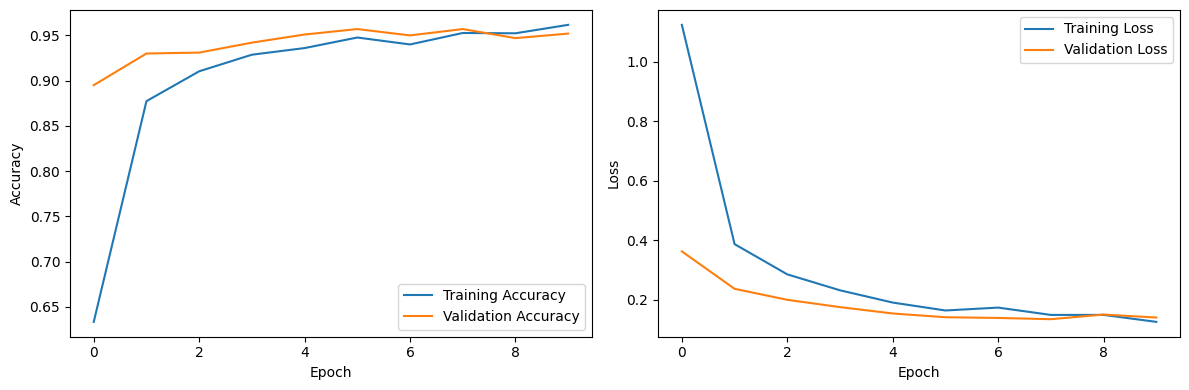

In [22]:
plot_history(mobilenet_history)

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 789ms/step - accuracy: 0.9816 - loss: 0.0774 - precision: 0.9885 - recall: 0.9789

MobileNet Test accuracy: 0.9820
MobileNet Test precision: 0.9879
MobileNet Test recall: 0.9780
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 369ms/step


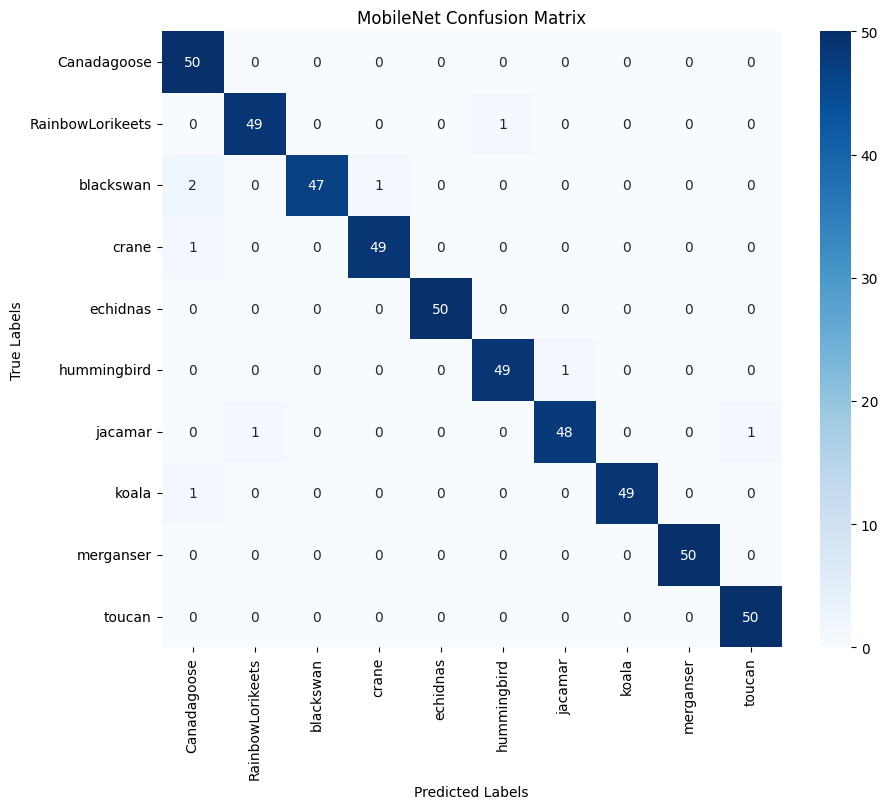

In [23]:
import seaborn as sns
test_generator.reset()  # Reset the generator before evaluating
test_loss, test_acc, test_precision, test_recall = mobilenet_model.evaluate(test_generator)
print(f'\nMobileNet Test accuracy: {test_acc:.4f}')
print(f'MobileNet Test precision: {test_precision:.4f}')
print(f'MobileNet Test recall: {test_recall:.4f}')

# Generate predictions for MobileNet
predictions = mobilenet_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes for MobileNet
true_classes = test_generator.classes

# Confusion Matrix for MobileNet
conf_mat = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix for MobileNet using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('MobileNet Confusion Matrix')
plt.show()

In [24]:
#4. InceptionV3
def evaluate_inception():
    # Special generator for Inception's 299x299 input
    inception_train_gen = train_datagen.flow_from_directory(
        train_dir, target_size=(299, 299), batch_size=batch_size)
    inception_val_gen = val_datagen.flow_from_directory(
        val_dir, target_size=(299, 299), batch_size=batch_size)

    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(299, 299, 3))
    x = tf.keras.applications.inception_v3.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy', 'precision', 'recall'])

    history = model.fit(
        inception_train_gen,
        validation_data=inception_val_gen,
        epochs=10,
        callbacks=[EarlyStopping(patience=3)]
    )

    return model, history

inception_model, inception_history = evaluate_inception()
model_comparison.append({
    'Model': 'InceptionV3',
    'Val Accuracy': max(inception_history.history['val_accuracy']),
    'Val Precision': max(inception_history.history['val_precision']),
    'Val Recall': max(inception_history.history['val_recall']),
    'Parameters': f"{inception_model.count_params():,}",
    'Inference Time': 'Medium',
    'Best For': 'Multi-scale features'
})

Found 3000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.1067 - loss: 2.3458 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.1600 - val_loss: 2.2131 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 92s 978ms/step - accuracy: 0.1750 - loss: 2.2297 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2160 - val_loss: 2.1572 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 93s 992ms/step - accuracy: 0.2105 - loss: 2.1661 - precision: 0.3789 - recall: 2.2375e-04 - val_accuracy: 0.3050 - val_loss: 2.0781 - val_precision: 1.0000 - val_recall: 0.0010
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 93s 995ms/step - accuracy: 0.2442 - loss: 2.1179 - precision: 0.7012 - recall: 0.0016 - val_accuracy: 0.2770 - val_loss: 2.0457 - val_precision: 0.6667 - val_recall: 0.0040
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 93s 980ms/step - accuracy: 0.2652 - loss: 2.0629 - precision: 0.6020 - recall: 0.002

In [25]:
#5. EfficientNet
def evaluate_efficientnet():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy', 'precision', 'recall'])

    history = model.fit(
        train_generator,
        validation_data= validation_generator,
        epochs=10,
        callbacks=[EarlyStopping(patience=3)]
    )

    return model, history

efficientnet_model, efficientnet_history = evaluate_efficientnet()
model_comparison.append({
    'Model': 'EfficientNetB0',
    'Val Accuracy': max(efficientnet_history.history['val_accuracy']),
    'Val Precision': max(efficientnet_history.history['val_precision']),
    'Val Recall': max(efficientnet_history.history['val_recall']),
    'Parameters': f"{efficientnet_model.count_params():,}",
    'Inference Time': 'Fast',
    'Best For': 'Best accuracy/efficiency tradeoff'
})

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.0987 - loss: 2.3384 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.1000 - val_loss: 2.3114 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 643ms/step - accuracy: 0.1064 - loss: 2.3286 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.1000 - val_loss: 2.3273 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 64s 685ms/step - accuracy: 0.0888 - loss: 2.3552 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.1000 - val_loss: 2.3060 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 645ms/step - accuracy: 0.1062 - loss: 2.3233 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.1000 - val_loss: 2.3063 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 60s 6

In [26]:
#Models comparison
import pandas as pd
comparison_df = pd.DataFrame(model_comparison)
comparison_df = comparison_df.sort_values('Val Accuracy', ascending=False)
comparison_df.style.background_gradient(cmap='Blues', subset=['Val Accuracy', 'Val Precision', 'Val Recall'])

,Model,Val Accuracy,Val Precision,Val Recall,Parameters,Inference Time,Best For
2,MobileNet,0.957000,0.965342,0.948000,"3,239,114",Fast,Mobile/Edge devices
0,VGG16,0.701000,1.000000,0.390000,"14,719,818",Medium,Medium-sized datasets
3,InceptionV3,0.352000,1.000000,0.016000,"21,823,274",Medium,Multi-scale features
1,ResNet50,0.261000,1.000000,0.010000,"23,608,202",Medium,General purpose
4,EfficientNetB0,0.105000,0.000000,0.000000,"4,062,381",Fast,Best accuracy/efficiency tradeoff


In [27]:
import pandas as pd
df=pd.read_csv('/content/drive/MyDrive/model_comparison.csv')
df

,Model,Val Accuracy,Val Precision,Val Recall,Parameters,Inference Time,Best For
0,MobileNet,0.904382,0.915638,0.886454,"3,232,964",Fast,Mobile/Edge devices
1,VGG16,0.711155,1.000000,0.500000,"14,716,740",Medium,Medium-sized datasets
2,ResNet50,0.581673,0.861538,0.185259,"23,595,908",Medium,General purpose
3,EfficientNetB0,0.320717,0.000000,0.000000,"4,054,695",Fast,Best accuracy/efficiency tradeoff


The best performing model is:
Model                       MobileNet
Val Accuracy                 0.904382
Val Precision                0.915638
Val Recall                   0.886454
Parameters                  3,232,964
Inference Time                   Fast
Best For          Mobile/Edge devices
Name: 0, dtype: object


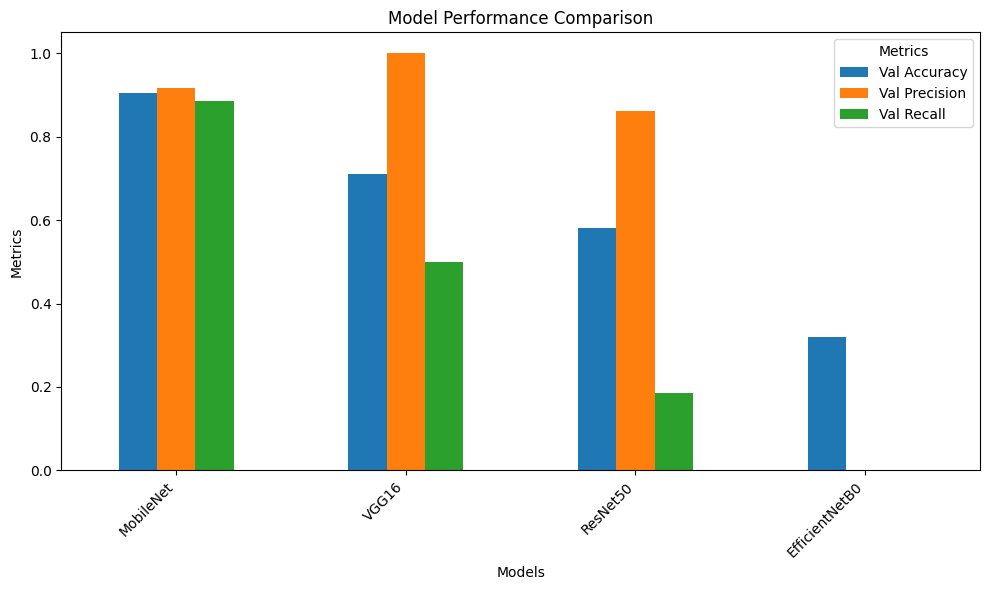

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/content/drive/MyDrive/model_comparison.csv')


# Find the best model based on validation accuracy
best_model = df.loc[df['Val Accuracy'].idxmax()]

print(f"The best performing model is:\n{best_model}")

# Plotting the bar chart
plt.figure(figsize=(10, 6))
df.plot(x='Model', y=['Val Accuracy', 'Val Precision', 'Val Recall'], kind='bar', ax=plt.gca())
plt.title('Model Performance Comparison')
plt.ylabel('Metrics')
plt.xlabel('Models')


plt.xticks(rotation=45, ha='right')
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()


In [29]:
#Save the model
mobilenet_model.save('/content/drive/MyDrive/model.h5')

In [30]:
#Streamlit App
!pip install streamlit numpy pillow tensorflow



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 99.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 137.8 MB/s eta 0:00:00


In [31]:
%%writefile app.py

import streamlit as st
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import os


classes = ['Canadagoose', 'RainbowLorikeets', 'blackswan', 'crane', 'echidnas', 'hummingbird', 'jacamar', 'koala', 'merganser', 'toucan']

# Load the trained model
@st.cache_resource
def load_custom_model():
    model_path = '/content/drive/MyDrive/model.h5'
    if not os.path.exists(model_path):
        st.error(f"Model file not found at {model_path}")
        return None
    return load_model(model_path)

model = load_custom_model()

# Streamlit app
st.title("Multi-Dataset Image Classification")
st.write(f"Upload a image to classify")

# File uploader
uploaded_file = st.file_uploader("Choose an image...",
                                type=["jpg", "jpeg", "png"])

if uploaded_file is not None and model is not None:
    # Display the uploaded image
    image = Image.open(uploaded_file)
    st.image(image, caption='Uploaded Image', use_column_width=True)

    # Preprocess the image
    image = image.resize((224, 224))  # Match your model's expected input
    image_array = img_to_array(image)
    image_array = image_array / 255.0  # Normalize (if your model expects this)
    image_array = np.expand_dims(image_array, axis=0)

    # Make prediction
    with st.spinner('Identifying Image...'):
        predictions = model.predict(image_array)
        predicted_class = classes[np.argmax(predictions)]
        confidence = np.max(predictions)


    # Display results
    st.subheader("Predicted Results:")
    st.success(f"Image: {predicted_class}")
    st.info(f"Confidence: {confidence*100:.2f}%")

    # Show all class probabilities
    st.subheader("All Class Probabilities:")
    for i, (cls, prob) in enumerate(zip(classes, predictions[0])):
        st.write(f"{cls}: {prob*100:.2f}%")
        st.progress(float(prob))

Writing app.py


In [32]:
!wget -q -O - ipv4.icanhazip.com

34.19.113.90


In [ ]:
! streamlit run app.py & npx localtunnel --port 8501

⠙

⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋Need to install the following packages:
localtunnel@2.0.2
Ok to proceed? (y) 
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.19.113.90:8501

